In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dhbk-hb-2-channels-stacked-squared-0-100/stacked_gei-00.pkl
/kaggle/input/dhbk-hb-2-channels-stacked-squared-0-100/stacked_gei-01.pkl


In [21]:
import pickle

# open a file, where you stored the pickled data
pkl_file = open('/kaggle/input/dhbk-hb-2-channels-stacked-squared-0-100/stacked_gei-00.pkl', 'rb')

# dump information to that file
train_data = pickle.load(pkl_file)
pkl_file.close()
del pkl_file


In [4]:
# open a file, where you stored the pickled data
pkl_file = open('/kaggle/input/dhbk-hb-2-channels-stacked-squared-0-100/stacked_gei-01.pkl', 'rb')

# dump information to that file
test_data = pickle.load(pkl_file)
pkl_file.close()
del pkl_file


In [5]:
train_data[5][0].shape

torch.Size([2, 128, 128])

In [6]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

from torch.utils.data import Dataset

import os
import pandas as pd
from torchvision.io import read_image

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import numpy as np

from torchvision import transforms


In [7]:

class CustomImageDataset(Dataset):  
    def __init__(self, data_dict: {}):                
        self.data = []
        for key, values in data_dict.items():
            # value.squeeze(1) turns [3, 1, 128, 128] to [3, 128, 128]
            # key start from 1 to 100
            self.data.extend([[key - 1, value] for value in values])
            pass
        pass
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][1]
        label = self.data[idx][0]
        return image, label
    
    pass

In [8]:
BATCH_SIZE = 1024 
EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_CLASSES = len(train_data.keys())
PATCH_SIZE = 32
IMG_SIZE = 128
IN_CHANNELS = 2
NUM_HEADS = 8 # embed_dim must be divisible by num_heads
DROPOUT = 0.001#0.001
HIDDEN_DIM = 1024
ADAM_WEIGHT_DECAY = 0.006 # 0.0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 8
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_PATCHES, EMBED_DIM, NUM_HEADS, NUM_CLASSES

(16, 2048, 8, 100)

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
               num_patches=NUM_PATCHES, dropout=DROPOUT,
               in_channels=IN_CHANNELS):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=embed_dim,
                      kernel_size=patch_size,
                      stride=patch_size),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(
            torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(
            # one channel
            #torch.rand(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
            # 2 channels
            torch.rand(size=(1, num_patches + 2, embed_dim)), requires_grad=True)
            # 3 channels
            #torch.rand(size=(1, num_patches + 3, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)
        pass

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        #print(x.shape)
        x = torch.cat((cls_token, x), dim=1)
        #print(x.shape)
        #print(self.position_embeddings.shape)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x
    
    pass

In [10]:
class ViT(nn.Module):
    def __init__(self, num_patches, num_classes, patch_size, embed_dim,
               num_encoders, num_heads, hidden_dim, dropout,
               activation, in_channels):
        super().__init__()
        self.embedding_block = PatchEmbedding(
            embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim,
            dropout=dropout, activation=activation, batch_first=True)
        self.encoder_blocks = nn.TransformerEncoder(
            encoder_layer=encoder_layers, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
        pass

    def forward(self, x):
        x = self.embedding_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0])
        return x
        pass


In [11]:
training_data = CustomImageDataset(train_data)
testing_data = CustomImageDataset(test_data)

In [12]:
training_data[13]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 32)

In [13]:
from  pympler import asizeof
asizeof.asizeof(training_data[13][1])

32

In [14]:
import timeit

def train_epoch(net,dataloader,lr=0.01,
                optimizer=None,loss_fn = nn.CrossEntropyLoss()):
    # neu khong thiet lap ham toi uu hoa thi su dung Adam
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    # chuyen trang thai cua mo hinh sang trang thai huan luyen
    net.train()
    total_loss,acc,count = 0,0,0
    # duyet qua cac mau va nhan trong batch
    for features,labels in dataloader:
        # xoa cac thong tin dao ham cu da su dung
        optimizer.zero_grad()

        features,labels = features.to(device),labels.to(device)
        # tinh cac nhan dua tren trong so hien tai
        out = net(features)
        # tinh ham mat mat
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        # lan truyen nguoc tren do thi tinh toan tu goc den ngon
        # dau vao la cac la "leaf"
        # dau ra la goc "root"
        loss.backward()

        # cap nhat cac trong so va bias "do lech" cua  mo hinh
        optimizer.step()

        # cap nhat cac thong thay doi de in ra khi can
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.CrossEntropyLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            features,labels = features.to(device),labels.to(device)
            out = net(features)
            loss += loss_fn(out,labels)
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

# toan bo quy trinh huan luyen
def train(net,train_loader,test_loader,optimizer=None,
          lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    # dung adam neu can thiet
    #if optimizer is None:
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    # tu dien chua thong tin huan luyen
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    start = timeit.default_timer()
    tp = None
    # duyet qua cac epoch
    for ep in range(epochs):
        # huan luyen mo hinh, lay thong tin ve do chinh xac cua mo hinh hien tai
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        # do luong tinh chinh xac cua mo hinh hien tai voi du lieu kiem tra
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        

        # in ket qua ra man hinh
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.6f}, Val loss={vl:.6f}")
        #print(f"Epoch {ep:2}, Train acc={ta:.3f}, Train loss={tl:.6f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
        pass
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    return res

In [15]:
len(training_data)

18079

In [16]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
#del training_data
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE)

In [17]:
data_iterator = iter(train_dataloader)
imgs, labels = next(data_iterator)
#imgs[0].squeeze(1).shape
imgs[0].shape

torch.Size([2, 128, 128])

In [18]:
device

'cuda'

In [19]:
model = ViT(NUM_PATCHES, NUM_CLASSES, PATCH_SIZE, EMBED_DIM,
          NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT,
          ACTIVATION, IN_CHANNELS)

model = model.to(device)

# Wrap model with DataParallel to use multiple GPUs


if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS,
                       weight_decay=ADAM_WEIGHT_DECAY)



In [20]:

hist = train(model, train_dataloader, test_dataloader, 
             epochs=EPOCHS, optimizer=optimizer, loss_fn=criterion)

Epoch  0, Train acc=0.013, Val acc=0.009, Train loss=0.004664, Val loss=0.004617
Epoch  1, Train acc=0.012, Val acc=0.020, Train loss=0.004589, Val loss=0.004512
Epoch  2, Train acc=0.028, Val acc=0.044, Train loss=0.004420, Val loss=0.004184
Epoch  3, Train acc=0.047, Val acc=0.055, Train loss=0.004137, Val loss=0.003964
Epoch  4, Train acc=0.064, Val acc=0.085, Train loss=0.003902, Val loss=0.003719
Epoch  5, Train acc=0.104, Val acc=0.070, Train loss=0.003646, Val loss=0.003928
Epoch  6, Train acc=0.228, Val acc=0.264, Train loss=0.002959, Val loss=0.002746
Epoch  7, Train acc=0.318, Val acc=0.316, Train loss=0.002612, Val loss=0.002465
Epoch  8, Train acc=0.470, Val acc=0.433, Train loss=0.001931, Val loss=0.002021
Epoch  9, Train acc=0.562, Val acc=0.519, Train loss=0.001574, Val loss=0.001743
Epoch 10, Train acc=0.729, Val acc=0.575, Train loss=0.001061, Val loss=0.001444
Epoch 11, Train acc=0.837, Val acc=0.715, Train loss=0.000694, Val loss=0.001074
Epoch 12, Train acc=0.855, V

In [22]:
torch.save(model, '/kaggle/working/model_train_99_test_85')

In [23]:
hist2 = train(model, train_dataloader, test_dataloader, 
             epochs=10, optimizer=optimizer, loss_fn=criterion)

Epoch  0, Train acc=0.995, Val acc=0.864, Train loss=0.000081, Val loss=0.000527
Epoch  1, Train acc=0.994, Val acc=0.860, Train loss=0.000078, Val loss=0.000544
Epoch  2, Train acc=0.993, Val acc=0.871, Train loss=0.000079, Val loss=0.000519
Epoch  3, Train acc=0.995, Val acc=0.876, Train loss=0.000075, Val loss=0.000491
Epoch  4, Train acc=0.996, Val acc=0.879, Train loss=0.000068, Val loss=0.000481
Epoch  5, Train acc=0.996, Val acc=0.883, Train loss=0.000064, Val loss=0.000484
Epoch  6, Train acc=0.997, Val acc=0.883, Train loss=0.000056, Val loss=0.000470
Epoch  7, Train acc=0.998, Val acc=0.875, Train loss=0.000055, Val loss=0.000508
Epoch  8, Train acc=0.996, Val acc=0.878, Train loss=0.000062, Val loss=0.000492
Epoch  9, Train acc=0.996, Val acc=0.886, Train loss=0.000061, Val loss=0.000466
Time:  728.506965949


In [24]:
torch.save(model, '/kaggle/working/model_train_996_test_886')

In [25]:
hist3 = train(model, train_dataloader, test_dataloader, 
             epochs=10, optimizer=optimizer, loss_fn=criterion)

Epoch  0, Train acc=0.995, Val acc=0.881, Train loss=0.000059, Val loss=0.000478
Epoch  1, Train acc=0.997, Val acc=0.885, Train loss=0.000052, Val loss=0.000450
Epoch  2, Train acc=0.994, Val acc=0.869, Train loss=0.000070, Val loss=0.000493
Epoch  3, Train acc=0.987, Val acc=0.866, Train loss=0.000095, Val loss=0.000509
Epoch  4, Train acc=0.993, Val acc=0.890, Train loss=0.000063, Val loss=0.000438
Epoch  5, Train acc=0.998, Val acc=0.902, Train loss=0.000044, Val loss=0.000409
Epoch  6, Train acc=0.999, Val acc=0.903, Train loss=0.000039, Val loss=0.000401
Epoch  7, Train acc=0.999, Val acc=0.909, Train loss=0.000037, Val loss=0.000384
Epoch  8, Train acc=0.999, Val acc=0.902, Train loss=0.000034, Val loss=0.000400
Epoch  9, Train acc=0.999, Val acc=0.909, Train loss=0.000035, Val loss=0.000384
Time:  728.8055893830001


In [28]:
torch.save(model, '/kaggle/working/model_train_999_test_909')
torch.save(model.state_dict(), '/kaggle/working/model_weight_train_999_test_909')

In [30]:
hist4 = train(model, train_dataloader, test_dataloader, 
             epochs=5, optimizer=optimizer, loss_fn=criterion)

Epoch  0, Train acc=0.552, Val acc=0.400, Train loss=0.001977, Val loss=0.002542


KeyboardInterrupt: 

In [ ]:
torch.save(model, '/kaggle/working/model_train_100_test_82')
torch.save(model.state_dict(), '/kaggle/working/model_weight_train_100_test_82')

In [31]:
hist5 = {}
for key in hist.keys():
    tmp = []
    tmp.extend(hist[key])
    tmp.extend(hist2[key])
    tmp.extend(hist3[key])
    hist5[key] = tmp    
    pass

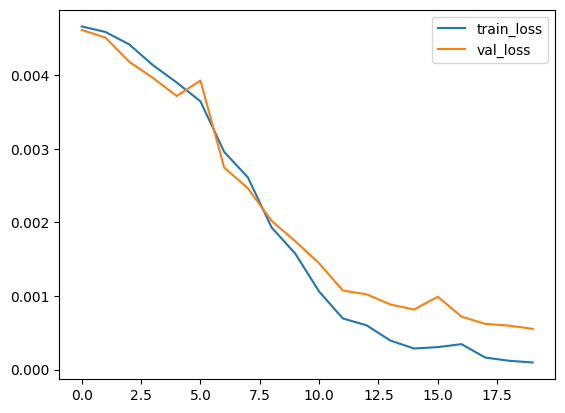

In [32]:
import matplotlib.pyplot as plt

plt.plot(hist['train_loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

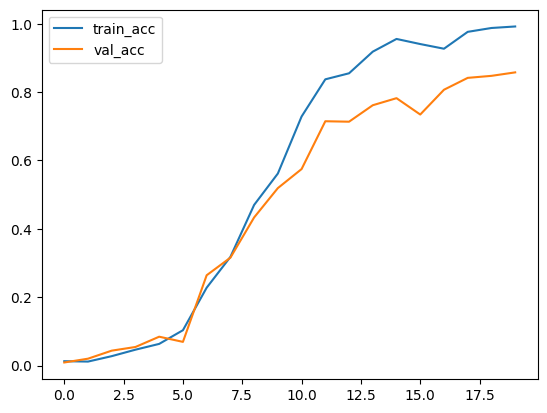

In [33]:
plt.plot(hist['train_acc'], label='train_acc')
plt.plot(hist['val_acc'], label='val_acc')
# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [34]:
import pickle
with open('hist.pkl', 'wb') as fp:
    pickle.dump(hist5, fp)    